In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fermat import Fermat
from sklearn.datasets import load_iris, load_digits
import networkx as nx
# import igraph as ig
# import neo4j


In [3]:
X, y = load_iris(return_X_y=True, as_frame=True)
N = len(X)  # # observaciones
K = len(set(y))  # # clases


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    *load_iris(return_X_y=True, as_frame=True), test_size=0.2
)


In [5]:
import scipy


In [6]:
from sklearn.neighbors import KernelDensity
import numpy as np

# rng = np.random.RandomState(42)
runs = 200
res = np.empty(runs)
n, d = 1000, 3
test_size = 10


In [7]:
int(1.2)


1

In [8]:
for i in range(runs):
    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(X[:test_size])
    log_density = kde.score_samples(X)
    res[i] = log_density[:test_size].mean() > log_density[test_size:].mean()
res.mean()


1.0

In [9]:
X_iris, _ = load_iris(return_X_y=True)
n, d = X_iris.shape
datasets = {"iris": X_iris, "unif(0, 1)": np.random.random_sample((n, d))}
(n, d), X_iris[:5]


((150, 4),
 array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2]]))

Qué probabilidad $p$ hay de que en la densidad estimatada sea, en promedio, más alta en el _train set_ que en un _test set_ aún no visto?
Con un _test set_ pequeño en relación al de _train_, esperaría que la densidad esté bien estimada en todo el dominio de la X y entonces $p >= 1/2 + \delta$, con un $\delta$ "pequeño", ya que $E_{X_{train}}(\hat{f_X}(X)) \approx E_{X_{test}}(\hat{f_X}(X))$. Coun un test set "grande", de tamaño cercano a $n$, la estimación de densidad,e la densidad esté sobreajustada a los puntos conocidos, y siempre dé 


In [10]:
def run(train_size, runs=100):
    results = {name: np.empty(runs) for name in datasets}
    for i in range(runs):
        for name, X in datasets.items():
            X_train, X_test = train_test_split(X, train_size=train_size)
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(X_train)
            results[name][i] = (
                kde.score_samples(X_train).mean() > kde.score_samples(X_test).mean()
            )
    return pd.DataFrame(results)


 Ajustar bien la densidad es `facil` entrenando con "casi todos" los datos y `dificil` entrenando con "casi ninguno" de los datos.

In [11]:
facil, dificil = 0.9, 0.1
runs = 100
favorable, adverso = run(facil, runs), run(dificil, runs)


In [12]:
res = pd.concat(
    [favorable, adverso], keys=["favorable", "adverso"], names=["modo", "run"]
)


In [13]:
res.groupby("modo").mean()


,iris,"unif(0, 1)"
modo,,
adverso,1.00,0.98
favorable,0.65,0.62


Bingo! En el contexto `favorable` de entrenamiento, la densidad estimada está más ajustada a los datos de _train_ que _test_, pero no siempre. En particular, el sobreajuste se nota más en el dataset real, `iris`, que en el sintético y "puramente aleatorio" `unif(0, 1)`.
En el contexto adverso, (casi) siempre la densidad estimada sobreajusta a train: en el dataset real "siempre" lo hace, mientras que en el sintético, alguna rara vez no se evidencia sobreajuste.

### Comparación de del humilde `EuclideanKDE` con la implementación de `scikit-learn`, `KernelDensity`

In [14]:
norm_pdf = scipy.stats.norm.pdf


class EuclideanKDE:
    def __init__(self, kernel=norm_pdf, bandwidth=1):
        self.kernel = kernel
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = (self.bandwidth**-self.dim_) * self.kernel(
            distance_matrix(X, self.X_) / self.bandwidth
        ).mean(axis=1)
        return np.log(densities) if log else densities


In [15]:
X = datasets["iris"]


In [16]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X)
sk_kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(X)


In [17]:
my_score = my_kde.density(X)
sk_score = sk_kde.score_samples(X)


In [18]:
my_score[:5], sk_score[:5]


(array([-2.15285911, -2.21996845, -2.21470712, -2.24684872, -2.16204292]),
 array([-4.90967471, -4.97678405, -4.97152272, -5.00366432, -4.91885852]))

No se ven iguales pero pareciera haber una proporcionalidad

In [19]:
from sklearn.linear_model import LinearRegression


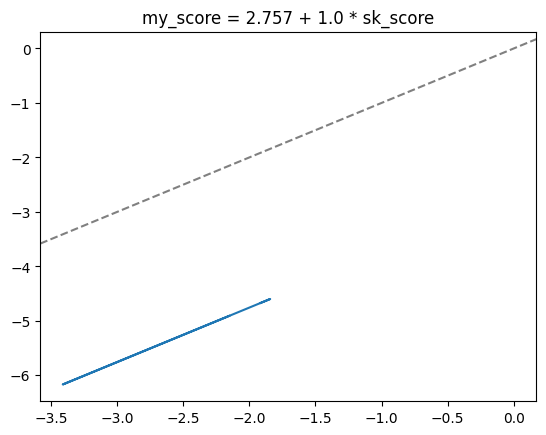

In [20]:
plt.plot(my_score, sk_score)
plt.axline([0, 0], slope=1, linestyle="dashed", color="gray")
est = LinearRegression().fit(X=sk_score.reshape(-1, 1), y=my_score)
plt.title(f"my_score = {est.intercept_.round(3)} + {est.coef_[0].round(3)} * sk_score")
plt.show()


Efectivamente, la relación pareciera de identidad, salvo por una sospechosa constante $\approx2.757$. Hmmmm. Al menos, parecieran funcionar igual. Revisando la documentación de [`KernelDensity.score_samples`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html?highlight=kerneldensity#sklearn.neighbors.KernelDensity.score_samples), leo:

    Returns 
        density: ndarray of shape (n_samples,)

        Log-likelihood of each sample in X. These are normalized to be probability densities, so values will be low for high-dimensional data.

Y en el código fuente, se lee (editado):

```python
        N = self.tree_.data.shape[0]
        log_density = self.tree_.kernel_density(X, h=self.bandwidth, kernel=self.kernel)
        log_density -= np.log(N)
        return log_density
```

Veamos si podemos revertir esa "normalización" de `log_density -= np.log(N)`:


In [21]:
N = sk_kde.tree_.data.shape[0]
N, N == X.shape[0]


(150, True)

In [22]:
atol_N = sk_kde.atol * N
log_density = sk_kde.tree_.kernel_density(
    X,
    h=sk_kde.bandwidth,
    kernel=sk_kde.kernel,
    atol=atol_N,
    rtol=sk_kde.rtol,
    breadth_first=sk_kde.breadth_first,
    return_log=True,
)


In [23]:
assert np.allclose(sk_score + np.log(N), log_density)


In [24]:
my_score[:5], log_density[:5]


(array([-2.15285911, -2.21996845, -2.21470712, -2.24684872, -2.16204292]),
 array([0.10096059, 0.03385124, 0.03911257, 0.00697097, 0.09177677]))

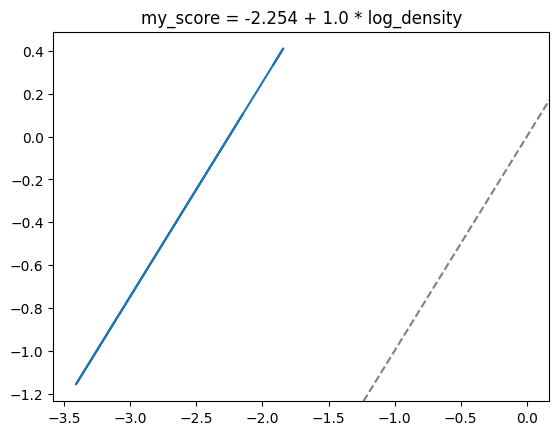

In [25]:
plt.plot(my_score, log_density)
plt.axline([0, 0], slope=1, linestyle="dashed", color="gray")
est = LinearRegression().fit(X=log_density.reshape(-1, 1), y=my_score)
plt.title(
    f"my_score = {est.intercept_.round(3)} + {est.coef_[0].round(3)} * log_density"
)
plt.show()


El problema, es que esa desnormalización, no es del factor esperado:

In [26]:
np.log(N), LinearRegression().fit(X=sk_score.reshape(-1, 1), y=my_score).intercept_


(5.0106352940962555, 2.756815599614004)

Qué más hay de distinto? Habrán normalizado los datos sin avisar? La `data` (nuestra `X`) del estimador de densidad se accede desde `KernelDensity.tree_.data`, que es una `MemoryView` del array original.

In [27]:
sk_data = np.asarray(sk_kde.tree_.data)
assert np.all(sk_data == X)


No, tampoco es eso. Bueno, ya se verá. Por el momento, son funcionalmente idénticas las implementaciones, salvo por esa constante.

In [28]:
# TODO: review normalizing factors in BinaryTree.kernel_density
factor = 0.5 * d * np.log(2 * np.pi)
factor
# -factor - d * np.log(1)

3.6757541328186907

### Comparación de Performance

In [30]:
X_digits = load_digits(return_X_y=True)[0]

In [31]:
%%timeit
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits)

422 ns ± 3.79 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [32]:
%%timeit
sk_kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(X_digits)

802 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


`fit` es esencialmente "gratis", algunas pocas asignaciones en ambos casos.

In [33]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits)


In [34]:
%%timeit
my_kde.density(X_digits)

460 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
sk_kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(X_digits)


In [36]:
%%timeit
sk_kde.score_samples(X_digits)

218 ms ± 7.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
X_digits.shape


(1797, 64)

In [63]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_iris)


In [64]:
%%timeit
my_kde.density(X_iris)

799 µs ± 4.18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [65]:
sk_kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(X_iris)


In [66]:
%%timeit
sk_kde.score_samples(X_iris)

835 µs ± 9.15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [67]:
X_digits.shape, X_iris.shape


((1797, 64), (150, 4))

Los resultados para `my_kde`, por ejemplo:
```
digits: 1.44 s ± 219 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
iris:  2.23 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
```

In [68]:
1440 / 2.23, 1797 / 150


(645.7399103139013, 11.98)

Ajustar `digits` toma 645 veces más tiempo que `iris`, con 12 veces más observaciones (pero claro, también 60 dimensiones más).


In [69]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits)


In [70]:
%%timeit
my_kde.density(X_digits)

465 ms ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [71]:
%%timeit
my_kde.density(X_digits[:180])

48.2 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Parece lineal en `n`.

In [72]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits[:, :8])


In [73]:
%%timeit
my_kde.density(X_digits[:,:8])

159 ms ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
X_digits[:, :16].mean(axis=0)

array([0.00000000e+00, 3.03839733e-01, 5.20478575e+00, 1.18358375e+01,
       1.18480801e+01, 5.78185865e+00, 1.36227045e+00, 1.29660545e-01,
       5.56483027e-03, 1.99387869e+00, 1.03823038e+01, 1.19794101e+01,
       1.02793545e+01, 8.17584864e+00, 1.84641068e+00, 1.07957707e-01])

In [81]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits[:, :16])


In [82]:
my_kde.density(X_digits[:,:16])

array([-8.41278469, -8.4126765 , -8.32232739, ..., -8.41241816,
       -8.38305759, -8.41281242])

In [83]:
%%timeit
my_kde.density(X_digits[:,:16])

185 ms ± 6.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [84]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits[:, :32])


In [85]:
%%timeit
my_kde.density(X_digits[:,:32])

252 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
n_dims = np.linspace(8, 64, 8).astype(int)
runs = 4

In [87]:
import time

In [88]:
results = []
for n_dim in n_dims:
    X = X_digits[:, :n_dim]
    my_kde = EuclideanKDE().fit(X)
    for i in range(runs):
        t0 = time.time()
        my_kde.density(X)
        t = time.time() - t0
        results.append({"n_dim": n_dim, "run": i, "time": t})

In [89]:
res = pd.DataFrame(results)

In [90]:
est = LinearRegression().fit(res[["n_dim"]], res.time)

In [91]:
est.intercept_, est.coef_

(0.09424373294625957, array([0.00555277]))

In [93]:
sk_kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(X_digits)


In [94]:
%%timeit
sk_kde.score_samples(X_digits)

212 ms ± 832 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
np.log(N) + est.intercept_


5.104879027042515

In [96]:
X_digits = load_digits(return_X_y=True)[0]


In [97]:
np.exp(my_score).sum()


17.06099545212962

In [98]:
sk_kde.tree_


In [99]:
my_score[:5], sk_kde.tree_.kernel_density(
    X[:5], h=sk_kde.bandwidth, kernel=sk_kde.kernel
)


(array([-2.15285911, -2.21996845, -2.21470712, -2.24684872, -2.16204292]),
 array([2.87239534e-26, 2.87239534e-26, 2.87239533e-26, 2.87239535e-26,
        2.87239535e-26]))

In [100]:
sk_score[:5] + np.log(X.shape[0])


array([2.58419918, 2.51708984, 2.52235116, 2.49020956, 2.57501536])

In [101]:
tree_data = np.asarray(kde.tree_.data)
tree_data.shape


(10, 4)

Cinco puntos desaparecieron, y 

In [102]:
np.mean(tree_data, axis=0), np.mean(X, axis=0)


(array([4.86, 3.31, 1.45, 0.22]),
 array([0.00000000e+00, 3.03839733e-01, 5.20478575e+00, 1.18358375e+01,
        1.18480801e+01, 5.78185865e+00, 1.36227045e+00, 1.29660545e-01,
        5.56483027e-03, 1.99387869e+00, 1.03823038e+01, 1.19794101e+01,
        1.02793545e+01, 8.17584864e+00, 1.84641068e+00, 1.07957707e-01,
        2.78241514e-03, 2.60155815e+00, 9.90317195e+00, 6.99276572e+00,
        7.09794101e+00, 7.80634391e+00, 1.78853645e+00, 5.00834725e-02,
        1.11296605e-03, 2.46967168e+00, 9.09126322e+00, 8.82136895e+00,
        9.92710072e+00, 7.55147468e+00, 2.31775181e+00, 2.22593211e-03,
        0.00000000e+00, 2.33945465e+00, 7.66722315e+00, 9.07178631e+00,
        1.03016138e+01, 8.74401781e+00, 2.90929327e+00, 0.00000000e+00,
        8.90372844e-03, 1.58375070e+00, 6.88146912e+00, 7.22815804e+00,
        7.67223150e+00, 8.23650529e+00, 3.45631608e+00, 2.72676683e-02,
        7.23427935e-03, 7.04507513e-01, 7.50695604e+00, 9.53923205e+00,
        9.41624930e+00, 8.7584

In [107]:
np.cov(my_kde.density(X), sk_kde.score_samples(X))


array([[7.6912014e-16, 7.6912007e-16],
       [7.6912007e-16, 7.6912000e-16]])

In [108]:
X, _ = load_iris(return_X_y=True)
n, d = X.shape
test_size = 90
runs = 100
datasets = {"iris": X, "unif(0, 1)": np.random.random_sample((n, d))}
results = {name: np.empty(runs) for name in datasets}
for name, X in datasets.items():
    X_train, X_test = train_test_split(X, test_size=test_size)
    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(X[:test_size])
    log_density = kde.score_samples(X)
    results[name][i] = log_density[:test_size].mean() > log_density[test_size:].mean()
    print(log_density[:test_size].mean(), log_density[test_size:].mean())


-2.6408225635111795 -5.4628583146095
-1.9608009197859162 -2.03105217277866


In [109]:
df = pd.DataFrame(results)


In [110]:
df.head()


,iris,"unif(0, 1)"
0,0.000000e+00,1.0
1,4.940656e-324,1.0
2,9.881313e-324,1.0
3,1.000000e+00,1.0
4,1.976263e-323,1.0


In [111]:
kde.score_samples(X[:80]).mean()


-1.9626422753735089

In [115]:
from numpy import random as rnd
import seaborn as sns


In [117]:
A = rnd.rand(100, 3)
A.sort(axis=1)
A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
a = A[0]
a, A[
    :5,
]


(array([0.        , 0.28451449, 0.46354107, 0.69441805, 1.        ]),
 array([[0.        , 0.28451449, 0.46354107, 0.69441805, 1.        ],
        [0.        , 0.21229501, 0.61954511, 0.77880377, 1.        ],
        [0.        , 0.04577322, 0.28389866, 0.37369717, 1.        ],
        [0.        , 0.02102351, 0.02422168, 0.4099341 , 1.        ],
        [0.        , 0.08672889, 0.27097745, 0.42247865, 1.        ]]))

In [118]:
def fermat_dist(x, alpha=1):
    """Fermat alpha-distance between `x_0` and `x_k`, in the line graph with nodes at `x = (x_1, ..., x_k)`."""
    return ((x[1:] - x[:-1]) ** alpha).sum()


In [119]:
np.apply_along_axis(fermat_dist, axis=1, arr=X, alpha=3).mean()


0.02184513266637519

In [120]:
sample_size = 1000
scales = [1 / 10, 1 / 2, 1, 2, 10]
alphas = np.linspace(1, 4, 7)
ks = [1, 2, 5, 10]
results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for scale in scales:
        for alpha in alphas:
            results.append(
                dict(
                    k=k,
                    alpha=alpha,
                    scale=scale,
                    dists=np.apply_along_axis(
                        fermat_dist, axis=1, arr=scale * A, alpha=alpha
                    ),
                )
            )


In [121]:
df = pd.DataFrame(results)


In [122]:
df["mean_dist"] = df.dists.apply(np.mean)
df["scaled_dist"] = df.mean_dist / (df.scale**df.alpha)


In [123]:
df.head()


,k,alpha,scale,dists,mean_dist,scaled_dist
0,1,1.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.100000,1.000000
1,1,1.5,0.1,"[0.024632885332512094, 0.024084993939469952, 0...",0.025240,0.798167
2,1,2.0,0.1,"[0.006330788552426433, 0.006014479556750364, 0...",0.006634,0.663412
3,1,2.5,0.1,"[0.0016727786722037716, 0.001541521156604129, ...",0.001794,0.567196
4,1,3.0,0.1,"[0.00044961828286396504, 0.0004021719335125546...",0.000495,0.495119


In [124]:
df[df.k == 1].pivot("alpha", "scale", "mean_dist").round(3)


/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21977/1517937895.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df[df.k == 1].pivot("alpha", "scale", "mean_dist").round(3)


scale,0.1,0.5,1.0,2.0,10.0
alpha,,,,,
1.0,0.100,0.500,1.000,2.000,10.000
1.5,0.025,0.282,0.798,2.258,25.240
2.0,0.007,0.166,0.663,2.654,66.341
2.5,0.002,0.100,0.567,3.209,179.363
3.0,0.000,0.062,0.495,3.961,495.119
3.5,0.000,0.039,0.439,4.968,1388.687
4.0,0.000,0.025,0.394,6.311,3944.339


In [125]:
df[df.k == 1].pivot("alpha", "scale", "scaled_dist").round(3)


/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21977/2761545792.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df[df.k == 1].pivot("alpha", "scale", "scaled_dist").round(3)


scale,0.1,0.5,1.0,2.0,10.0
alpha,,,,,
1.0,1.000,1.000,1.000,1.000,1.000
1.5,0.798,0.798,0.798,0.798,0.798
2.0,0.663,0.663,0.663,0.663,0.663
2.5,0.567,0.567,0.567,0.567,0.567
3.0,0.495,0.495,0.495,0.495,0.495
3.5,0.439,0.439,0.439,0.439,0.439
4.0,0.394,0.394,0.394,0.394,0.394


Está claro que si $c$ es la constance de escale `scale`, las distancias de fermat escalan según $c^{-\alpha}$. Ahora, cuánto cambian con el tamaño de muestra $k$? 

Para $k=1$, se puede calcular exactamente la esperanza de la longitud del camino. Si hay un único punto entre 0 y 1 elegido al azar según $X \sim \text{Unif}(0, 1)$, entonces la longitud del camino de Fermat cuando $alpha=2$ será $E\left(X^2 + (1-X)^2\right) = 2/3$, lo cual se ve en la tabla anterior. Para $k=1$ y otros valores de $\alpha$, la expresión no será tan bella pero es computable sin mucha dificultad. Para otros valores de $k$, sin embargo, ya entran en juego la distribución de los estadísticos de orden y no me resulta para nada evidente una fórmula cerrada.

Aproximémosla. Sean $X^{(0)} = 0, X^{(k+1)} = 1$ y $X^{(i)}, i=1,\dots,k$ las v.a. que surgen de ordenar una muestra $X_i \sim_{iid} \text{Unif}(0, 1), \ i\in[k]$. Para todo $k$ se cumple que cada "segmentito de recta", $\mathbb{E}\left(X^{(i+1)}-X^{(i)}\right) = 1 / (k + 1)$. Luego, esperaríamos que 

$$
\begin{align} dist_{\alpha}^k(0, 1) &= \mathbb{E}\ \left(\sum_{i=0}^k \left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &=  \sum_{i=0}^k\ \left( \mathbb{E}\left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &\approx (???) (k + 1) \left(\frac{1}{k+1}\right)^{\alpha}
   \end{align}

$$

Pero no vale que $E(X^k) = E(X)^k$! Qué se hace en su lugar? Hay que conocer la densidad de $X^{(i+1)}-X^{(i)}$ y calcularlo? Empíricamente, veamos como cambia la distancia con $k$.

In [126]:
df[df.scale == 1].pivot("alpha", "k", "scaled_dist")


/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21977/147100703.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df[df.scale == 1].pivot("alpha", "k", "scaled_dist")


k,1,2,5,10
alpha,,,,
1.0,1.000000,1.000000,1.000000,1.000000
1.5,0.798167,0.685156,0.511147,0.387143
2.0,0.663412,0.499052,0.285321,0.165992
2.5,0.567196,0.379623,0.170250,0.076966
3.0,0.495119,0.298262,0.107104,0.037995
3.5,0.439141,0.240263,0.070351,0.019754
4.0,0.394434,0.197427,0.047901,0.010731


In [127]:
df["k_scaled_dist"] = df.scaled_dist * ((df.k + 2) ** (df.alpha - 1))
df[df.scale == 1].assign().pivot("alpha", "k", "k_scaled_dist")


/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21977/1046065144.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df[df.scale == 1].assign().pivot("alpha", "k", "k_scaled_dist")


k,1,2,5,10
alpha,,,,
1.0,1.000000,1.000000,1.000000,1.000000
1.5,1.382466,1.370313,1.352368,1.341103
2.0,1.990237,1.996207,1.997246,1.991900
2.5,2.947239,3.036986,3.153072,3.199431
3.0,4.456067,4.772194,5.248083,5.471267
3.5,6.845538,7.688421,9.120476,9.853764
4.0,10.649715,12.635330,16.430004,18.543304


In [128]:
df


,k,alpha,scale,dists,mean_dist,scaled_dist,k_scaled_dist
0,1,1.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.100000,1.000000,1.000000
1,1,1.5,0.1,"[0.024632885332512094, 0.024084993939469952, 0...",0.025240,0.798167,1.382466
2,1,2.0,0.1,"[0.006330788552426433, 0.006014479556750364, 0...",0.006634,0.663412,1.990237
3,1,2.5,0.1,"[0.0016727786722037716, 0.001541521156604129, ...",0.001794,0.567196,2.947239
4,1,3.0,0.1,"[0.00044961828286396504, 0.0004021719335125546...",0.000495,0.495119,4.456067
...,...,...,...,...,...,...,...
135,10,2.0,10.0,"[13.263614129589545, 14.03217958804902, 15.448...",16.599168,0.165992,1.991900
136,10,2.5,10.0,"[16.30550118321392, 18.513598329674323, 22.583...",24.338894,0.076966,3.199431
137,10,3.0,10.0,"[20.711364600998888, 25.89156540248032, 35.552...",37.994910,0.037995,5.471267
138,10,3.5,10.0,"[27.018895545514702, 37.92266325240644, 58.731...",62.466767,0.019754,9.853764


In [129]:
sample_size = 1000
alphas = [1.5, 1.75, 2, 2.25, 3, 4, 5]
ks = np.array([*range(1, 11), *rnd.choice(range(11, 2001), 50, replace=False)])

results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for alpha in alphas:
        results.append(
            dict(
                k=k,
                alpha=alpha,
                dists=np.apply_along_axis(fermat_dist, axis=1, arr=A, alpha=alpha),
            )
        )

df = pd.DataFrame(results)
df["mean_dist"] = df.dists.apply(np.mean)


In [130]:
df[df.k < 50].pivot("alpha", "k", "mean_dist").round(3)


/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21977/1292338567.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df[df.k < 50].pivot("alpha", "k", "mean_dist").round(3)


k,1,2,3,4,5,6,7,8,9,10,21
alpha,,,,,,,,,,,
1.50,0.802,0.690,0.613,0.553,0.516,0.477,0.450,0.428,0.406,0.387,0.279
1.75,0.730,0.588,0.494,0.424,0.384,0.342,0.313,0.291,0.269,0.251,0.154
2.00,0.670,0.507,0.405,0.330,0.291,0.250,0.223,0.202,0.182,0.166,0.088
2.25,0.619,0.442,0.336,0.261,0.225,0.186,0.162,0.143,0.126,0.112,0.051
3.00,0.505,0.309,0.204,0.139,0.112,0.083,0.067,0.056,0.046,0.038,0.011
4.00,0.405,0.209,0.118,0.067,0.051,0.033,0.025,0.019,0.014,0.011,0.002
5.00,0.339,0.152,0.074,0.036,0.027,0.015,0.011,0.007,0.005,0.004,0.000


In [51]:
plt.figure(figsize=(16, 7))
sns.lineplot(x="k", y="mean_dist", hue="alpha", data=df, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.show()


NameError: name 'sns' is not defined

<Figure size 1600x700 with 0 Axes>

Para la elección del ancho de banda $h$ es necesario saber la escala de las distancias! Con qué se come esto???

In [52]:
results = []
for i in range(10000):
    s = rnd.rand(100)
    s.sort()
    dists = (np.array([s[0], *(s[1:] - s[:-1]), 1 - s[-1]])) ** 2
    results.append((dists.mean(), dists.std()))


NameError: name 'rnd' is not defined

In [53]:
np.mean([std / mean for mean, std in results])


/Users/gonzalo/.pyenv/versions/3.10.9/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gonzalo/.pyenv/versions/3.10.9/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

## Implementación KDEClassifier

In [ ]:
from scipy.stats import norm
from numpy.linalg import norm as euclidean_norm
from scipy.spatial import distance_matrix


In [34]:
import scipy

scipy.spatial.distance.minkowski(A[0], A[2])


0.5086494413404895

In [35]:
repr(fermat)


"Fermat(alpha=2, path_method='FW')"

In [36]:
B = range(5)
C = range(7)
[[b * c for c in C] for b in B]


[[0, 0, 0, 0, 0, 0, 0],
 [0, 1, 2, 3, 4, 5, 6],
 [0, 2, 4, 6, 8, 10, 12],
 [0, 3, 6, 9, 12, 15, 18],
 [0, 4, 8, 12, 16, 20, 24]]

In [37]:
(A[:] == A[2]).all(1)[:5]


array([False, False,  True, False, False])

In [38]:
A.shape, np.zeros(10)


((1000, 938), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [41]:
# WIP - ignore
def euclidean_distance(x, y):
    return euclidean_norm(x - y)


class FermatDistance(Fermat):
    def __init__(self, **kwargs):
        super.__init__(**kwargs)

    def _fit(self, X):
        self.fit(X)
        self.X_ = X
        self.n_, self.d_ = X.shape
        self.is_fitted_ = True
        return self

    def __call__(A, B):
        if self.alpha == 1:
            return distance_matrix(A, B)
        else:
            return [[self._get_distance(a, b) for a in A] for b in B]

    def _get_distance(a, b):
        if not self.is_fitted_:
            self._fit()
        if any((self.X_[:] == a).all(1)):  # `a` is a node from X_
            to_X = np.zeros(self.n_)
        else:
            to_X = euclidean_distances(a.reshape(1, -1), verts)[0] ** self.alpha

        if a_known := np.where((X[:] == 2 * X[2]).all(1)):
            to_nodes = euclidean_distances(a.reshape(1, -1), verts)[0] ** alpha


In [49]:
norm_pdf = scipy.stats.norm.pdf


class EuclideanKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            distance_matrix(X, self.X_) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities


In [52]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y  # , check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.special import softmax


class EuclideanKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: EuclideanKDE(self.kernel, self.bandwith).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [54]:
class FermatKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        self.fermat_ = Fermat(self.alpha, self.path_method).fit(distance_matrix(X, X))
        self.distances_ = self.fermat_.get_distances()
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            self.distances(X) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities

    def distances(self, X):
        distances_to_X = distance_matrix(X, self.X_) ** self.alpha
        return np.vstack([(d + self.distances_).min(axis=1) for d in distances_to_X])


In [55]:
from scipy.special import softmax


class FermatKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: FermatKDE(
                self.kernel, self.bandwith, self.alpha, self.path_method
            ).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [57]:
A = np.array([[i] * 2 for i in range(3)])
Fermat(2, "FW").fit(distance_matrix(A, A)).get_distances()


array([[0., 2., 4.],
       [2., 0., 2.],
       [4., 2., 0.]])

In [58]:
B = np.vstack([[-1, 0], [1, 0]])
B


array([[-1,  0],
       [ 1,  0]])

In [59]:
C = np.vstack([A, B])


In [60]:
full = Fermat(2, "FW").fit(distance_matrix(C, C))
full_dists = full.get_distances()


In [61]:
n_train = 120
train = FermatKDE(2, "FW").fit(A)
test_dists = train.distances(B)


In [62]:
full_dists, test_dists


(array([[0., 2., 4., 1., 1.],
        [2., 0., 2., 3., 1.],
        [4., 2., 0., 5., 3.],
        [1., 3., 5., 0., 2.],
        [1., 1., 3., 2., 0.]]),
 array([[1., 3., 5.],
        [1., 1., 3.]]))

In [63]:
full = Fermat(2, "FW").fit(distance_matrix(X, X))
full_dists = full.get_distances()


In [64]:
n_train = 120
train = FermatKDE(2, "FW").fit(X[:n_train])
test_dists = train.distances(X[n_train:])


In [71]:
np.where(full_dists[n_train:, :n_train] > test_dists + 0.001)


(array([22]), array([101]))

In [ ]:
full_dists[n_train:, :n_train][22, 101], test_dists[22, 101]


(0.1399999999999999, 0.0)

In [72]:
pd.Series((full_dists[n_train:, :n_train] - test_dists).flatten()).describe()


count    3.600000e+03
mean    -7.726667e-02
std      7.876425e-02
min     -4.600000e-01
25%     -1.200000e-01
50%     -6.000000e-02
75%     -4.440892e-16
max      1.400000e-01
dtype: float64

In [75]:
# Fermat distnaces between train obss, with X=train osbs, must be >= than
#   Fermat distances bw train obss, with X=(train obss + test obss)
assert (train.distances_ >= full_dists[:n_train, :n_train]).all()


```python
preds = []
fhats = []
for x in X_test:
    fhat = {}
    for cls in classes.keys():
        klass = classes[cls]
        verts, dists = klass["verts"], klass["dists"]
        n = verts.shape[0]
        to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
        fmt_dists = [min(to_verts + dists[:, i]) for i in range(n)]
        # print(cls, np.mean(fmt_dists))
        fhat[cls] = (1 / h**D) * np.mean([kern(d / h) for d in fmt_dists])
    fhats.append(fhat)
    preds.append(pd.Series(fhat).argmax())
```

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier


In [91]:
.shape

(898, 74)

In [108]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.90)
eucclf = EuclideanKDEClassifier().fit(X_train, y_train)
fmtclf = FermatKDEClassifier(alpha=2, bandwith=200).fit(X_train, y_train)
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf2 = RandomForestClassifier().fit(
    np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train
)


In [109]:
for clf in [eucclf, fmtclf, rfclf]:
    print(repr(clf), ": ", accuracy_score(clf.predict(X_test), y_test))
print(
    repr(rfclf2),
    " - enhanced: ",
    accuracy_score(
        rfclf2.predict(
            np.concatenate([X_test, fmtclf.decision_function(X_test)], axis=1)
        ),
        y_test,
    ),
)


/tmp/ipykernel_56471/1728847503.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


EuclideanKDEClassifier() :  0.9363411619283065
FermatKDEClassifier(bandwith=200) :  0.9400494437577256
RandomForestClassifier() :  0.907292954264524
RandomForestClassifier()  - enhanced:  0.934487021013597


In [287]:
accuracy_score(eucclf.predict(X_test), y_test), accuracy_score(
    fmtclf.predict(X_test), y_test
)


/tmp/ipykernel_206930/2399770987.py:24: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


(0.8666666666666667, 0.8333333333333334)

In [325]:
[x.shape for x in [X_train, X_test, y_train, y_test]]


[(35, 64), (1762, 64), (35,), (1762,)]

In [141]:
sp_softmax(D * 10, axis=1).round(3)


array([[0.   , 1.   , 0.   ],
       [0.   , 0.9  , 0.1  ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.   , 0.997, 0.003],
       [0.   , 0.001, 0.999],
       [1.   , 0.   , 0.   ],
       [0.   , 0.435, 0.565],
       [1.   , 0.   , 0.   ],
       [0.   , 0.021, 0.979],
       [0.   , 0.001, 0.999],
       [0.   , 0.637, 0.363],
       [0.   , 0.146, 0.854],
       [1.   , 0.   , 0.   ],
       [0.   , 0.001, 0.999],
       [1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 0.815, 0.185],
       [0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   ],
       [0.   , 0.506, 0.494],
       [0.   , 0.   , 1.   ],
       [0.   , 1.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.   , 0.992, 0.008],
       [1.   , 0.   , 0.   ],
       [0.   , 0.841, 0.159],
       [1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]])

In [136]:
(np.argmax(preds, axis=1) == y_test).mean()


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
X, y = load_iris(return_X_y=True)
N = len(X)  # # observaciones
K = len(set(y))  # # clases


In [ ]:
kde = KDEstimator()


In [ ]:
kde.fit(X[y == 0])


In [ ]:
kde.predict(X[-1])


0.00011495190242781194

In [ ]:
y[0]


0

## TemplateClassifier

In [58]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances


class TemplateClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, demo_param="demo"):
        self.demo_param = demo_param

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]


In [ ]:
unique_labels()
